### 依赖包导入

In [2]:
import argparse
import os
import random
from datetime import datetime
from IPython.display import Image, display

import numpy as np
import torch
import torch.distributed as dist

from exp.exp_forecast import Exp_Forecast
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_imputation import Exp_Imputation
from utils.tools import HiddenPrints

### 变量定义

In [ ]:
args = argparse.Namespace(
    # ===== basic config =====
    task_name="imputation",
    model_id="Timer_multivariate_imputation",
    model="Timer_multivariate",
    seed=42,

    # ===== data loader =====
    data="multivariate",
    root_path="./dataset/xw/elec",
    data_path="ETTh1.csv",
    features="M",
    target="OT",
    freq="h",
    checkpoints="./checkpoints/",
    inverse=False,

    # ===== model define =====
    d_model=256,
    n_heads=8,
    e_layers=4,
    d_layers=1,
    d_ff=512,
    factor=3,
    distil=True,
    dropout=0.1,
    embed="timeF",
    activation="gelu",
    output_attention=False,
    use_norm=True,
    max_len=10000,
    mask_flag=True,
    binary_bias=False,
    covariate=True,
    n_pred_vars=15,
    freeze_layer=False,

    # ===== optimization =====
    num_workers=10,
    itr=1,
    train_epochs=10,
    batch_size=64,
    patience=3,
    learning_rate=1e-4,
    des="test",
    loss="MSE",
    lradj="type1",
    use_amp=False,

    # ===== GPU =====
    use_gpu=True,
    gpu=0,
    use_multi_gpu=False,
    devices="0,1,2,3",

    # ===== misc =====
    stride=1,
    ckpt_path="checkpoints/Timer_imputation_1.0.ckpt",
    finetune_epochs=10,
    finetune_rate=0.1,
    local_rank=0,

    patch_len=24,
    subset_rand_ratio=1.0,
    data_type="custom",

    decay_fac=0.75,

    # ===== cosine decay =====
    cos_warm_up_steps=100,
    cos_max_decay_steps=60000,
    cos_max_decay_epoch=10,
    cos_max=1e-4,
    cos_min=2e-6,

    # ===== weight decay =====
    use_weight_decay=0,
    weight_decay=0.01,

    # ===== autoregressive configs =====
    use_ims=True,
    output_len=96,
    output_len_list=None,

    # ===== train_test =====
    train_test=0,
    valid_ratio=0.2,
    is_finetuning=1,
    test_dir="test_results",
    test_version="test",  # 可选 "test", "predict", "auto_process", "prune", "visualize"
    prune_ratio=0.2,
    remove_mask=False,

    # ===== forecasting task =====
    seq_len=192,
    label_len=48,
    pred_len=0,
    input_len=0,

    # ===== imputation task =====
    mask_rate=0.125,

    # ===== anomaly detection task =====
    loss_threshold=5.0,

    # ===== opacus options =====
    use_opacus=False,
    noise_multiplier=1.1,
    max_grad_norm=1.0,

    # ===== training info visualize configs =====
    record_info=False,
)

fix_seed = args.seed
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_multi_gpu:
    ip = os.environ.get("MASTER_ADDR", "127.0.0.1")
    port = os.environ.get("MASTER_PORT", "64209")
    hosts = int(os.environ.get("WORLD_SIZE", "8"))  # number of nodes
    rank = int(os.environ.get("RANK", "0"))  # node id
    local_rank = int(os.environ.get("LOCAL_RANK", "0"))
    gpus = torch.cuda.device_count()  # gpus per node
    args.local_rank = local_rank
    print(
        'ip: {}, port: {}, hosts: {}, rank: {}, local_rank: {}, gpus: {}'.format(ip, port, hosts, rank, local_rank,
                                                                                    gpus))
    dist.init_process_group(backend="nccl", init_method=f"tcp://{ip}:{port}", world_size=hosts, rank=rank)
    print('init_process_group finished')
    torch.cuda.set_device(local_rank)

### 训练数据读取和插补数据生成

In [14]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    # setting record of experiments
    setting = f"{args.model}_{args.task_name}_{args.data}_d{args.d_model}_n{args.n_heads}_l{args.e_layers}_itr0_"
    setting += datetime.now().strftime("%y-%m-%d_%H-%M-%S")
    print(f"checkpoints folder are $root/checkpoints/{setting}.")
    print(f"test_results folder are $root/test_results/{setting}.")

    exp = Exp_Imputation(args)  # set experiments
    trainset, trainloader = exp._get_data(flag="train")
    print(f"Number of samples in trainset: {len(trainset)}")
    print(f"Number of batches in trainloader: {len(trainloader)}")
    mask_set, mask_loader = exp._mask_data(flag="train")
    tensor = mask_set.tensors if hasattr(mask_set, "tensors") else mask_set.tensor
    # 保存为 PyTorch 二进制文件
    # torch.save(tensor, os.path.join(args.checkpoints, setting, f"{filename}_train.pt"))
    
    inp, mask = mask_set[0]
    print(f"First sample in trainset, input: {inp}, mask: {mask}")


checkpoints folder are $root/checkpoints/Timer_multivariate_imputation_multivariate_d1024_n8_l8_itr0_25-09-07_16-58-52.
test_results folder are $root/test_results/Timer_multivariate_imputation_multivariate_d1024_n8_l8_itr0_25-09-07_16-58-52.
Use GPU: cuda:0
Number of samples in trainset: 272
Number of batches in trainloader: 5
First sample in trainset, input: tensor([[  6.,   6.,   6.,  ...,   6.,   6.,   6.],
        [  7.,   7.,   7.,  ...,   7.,   7.,   7.],
        [  8.,   8.,   8.,  ...,   8.,   8.,   8.],
        ...,
        [675., 675., 675.,  ..., 675., 675., 675.],
        [676., 676., 676.,  ..., 676., 676., 676.],
        [677., 677., 677.,  ..., 677., 677., 677.]]), mask: tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


### 模型训练

In [8]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.finetune(setting)

>>>>>>>start training : Timer_multivariate_imputation_multivariate_d1024_n8_l8_itr0_25-09-07_16-52-40>>>>>>>>>>>>>>>>>>>>>>>>>>
train steps per epoch: 4.0
Epoch: 1 cost time: 4.642961740493774
Epoch: 1, Steps: 5 | Train Loss: 26918.2662109 Vali Loss: 9070.2958984
Validation loss decreased (inf --> 9070.295898).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 4.550428867340088
Epoch: 2, Steps: 5 | Train Loss: 7663.0661133 Vali Loss: 4594.1660156
Validation loss decreased (9070.295898 --> 4594.166016).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 4.622284173965454
Epoch: 3, Steps: 5 | Train Loss: 4894.7108398 Vali Loss: 3049.6552734
Validation loss decreased (4594.166016 --> 3049.655273).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 4.487482309341431
Epoch: 4, Steps: 5 | Train Loss: 3656.1217773 Vali Loss: 2178.1232910
Validation loss decreased (3049.655273 --> 2178.123291).  Saving model ...
Updating learning rat

### 测试数据生成和插补缺失数据保存（可选，如需要请取消注释代码，保存位置在checkpoints保存位置的文件夹下）

In [ ]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    testset, testloader = exp._get_data(flag="test")
    print(f"Number of samples in testset: {len(testset)}")
    print(f"Number of batches in testloader: {len(testloader)}")
    # 如果是需要通过人为的方式mask掉一部分数据进行测试，则使用test_version="test"
    # 如果是测试数据中天然含有nan缺失值，则使用test_version="auto_process"
    mask_set, mask_loader = exp._mask_data(flag="test", test_version=args.test_version)
    tensor = mask_set.tensors if hasattr(mask_set, "tensors") else mask_set.tensor
    # 保存为 PyTorch 二进制文件
    # torch.save(tensor, os.path.join(args.checkpoints, setting, f"{filename}_test.pt"))
    
    inp, mask = mask_set[0]
    print(f"First sample in testset, input: {inp}, mask: {mask}")

>>>>>>>testing : Timer_multivariate_imputation_multivariate_d1024_n8_l8_itr0_25-09-07_16-52-40<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Number of samples in testset: 24
Number of batches in testloader: 24
First sample in testset, input: tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
        [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
        ...,
        [669., 669., 669.,  ..., 669., 669., 669.],
        [670., 670., 670.,  ..., 670., 670., 670.],
        [671., 671., 671.,  ..., 671., 671., 671.]]), mask: tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


### 模型测试

In [13]:
with HiddenPrints(int(os.environ.get("LOCAL_RANK", "0"))):
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

>>>>>>>testing : Timer_multivariate_imputation_multivariate_d1024_n8_l8_itr0_25-09-07_16-52-40<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


mse:7121.2392578125, mae:72.84417724609375


In [ ]:
test_result_dir = os.path.join(args.test_dir, setting, f"subset{args.subset_rand_ratio}_mask{args.mask_rate}")
image_path_list = [f for f in os.listdir(test_result_dir) if f.endswith('.png')]
for idx, image_path in enumerate(image_path_list):
    print(f"{idx}: {image_path}")

0: feat_15_of_test_data_13th.png
1: feat_7_of_test_data_11th.png
2: feat_11_of_test_data_5th.png
3: feat_4_of_test_data_5th.png
4: feat_3_of_test_data_1th.png
5: feat_4_of_test_data_1th.png
6: feat_9_of_test_data_1th.png
7: feat_8_of_test_data_21th.png
8: feat_12_of_test_data_21th.png
9: feat_13_of_test_data_11th.png
10: feat_2_of_test_data_18th.png
11: feat_12_of_test_data_8th.png
12: feat_5_of_test_data_1th.png
13: feat_14_of_test_data_0th.png
14: feat_12_of_test_data_18th.png
15: feat_13_of_test_data_13th.png
16: feat_14_of_test_data_5th.png
17: feat_2_of_test_data_13th.png
18: feat_10_of_test_data_8th.png
19: feat_3_of_test_data_8th.png
20: feat_14_of_test_data_16th.png
21: feat_13_of_test_data_5th.png
22: feat_7_of_test_data_8th.png
23: feat_5_of_test_data_13th.png
24: feat_8_of_test_data_0th.png
25: feat_1_of_test_data_5th.png
26: feat_5_of_test_data_0th.png
27: feat_11_of_test_data_18th.png
28: feat_12_of_test_data_5th.png
29: feat_6_of_test_data_21th.png
30: feat_15_of_test_dat

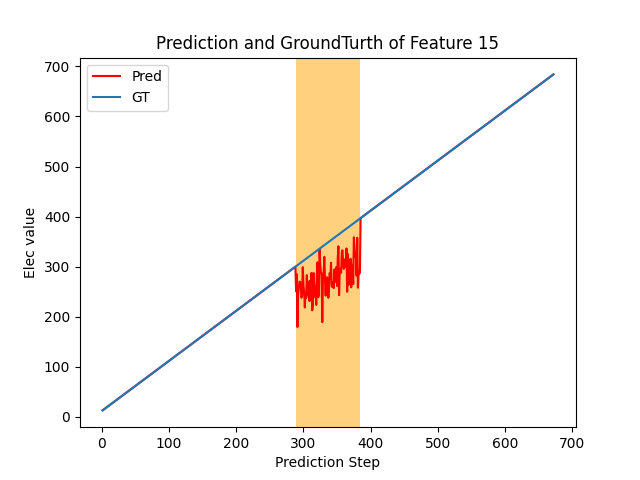

In [5]:
default_image_idx = 0
display(Image(filename=os.path.join(test_result_dir, image_path_list[default_image_idx])))